<h1>Assignment 1 - Question 3</h1>


In [145]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


plt.style.use("ggplot")
np.random.seed(37)
warnings.filterwarnings("ignore")

<img src="/Users/pradnyeshchoudhari/EECE 5644 - LOCAL/Assignments/Assignment 01/Images/3.png">


In [146]:
winequality_red_df = pd.read_csv(
    "/Users/pradnyeshchoudhari/EECE 5644 - LOCAL/Assignments/Assignment 01/wine+quality/winequality-red.csv",
    delimiter=";",
)
winequality_white_df = pd.read_csv(
    "/Users/pradnyeshchoudhari/EECE 5644 - LOCAL/Assignments/Assignment 01/wine+quality/winequality-white.csv",
    delimiter=";",
)

In [147]:
X_train = pd.read_csv(
    "/Users/pradnyeshchoudhari/EECE 5644 - LOCAL/Assignments/Assignment 01/human+activity+recognition+using+smartphones/UCI HAR Dataset/train/X_train.txt",
    delim_whitespace=True,
    header=None,
)

In [148]:
X_test = pd.read_csv(
    "/Users/pradnyeshchoudhari/EECE 5644 - LOCAL/Assignments/Assignment 01/human+activity+recognition+using+smartphones/UCI HAR Dataset/test/X_test.txt",
    delim_whitespace=True,
    header=None,
)

In [149]:
Y_train = pd.read_csv(
    "/Users/pradnyeshchoudhari/EECE 5644 - LOCAL/Assignments/Assignment 01/human+activity+recognition+using+smartphones/UCI HAR Dataset/train/y_train.txt",
    delim_whitespace=True,
    header=None,
)

In [150]:
Y_test = pd.read_csv(
    "/Users/pradnyeshchoudhari/EECE 5644 - LOCAL/Assignments/Assignment 01/human+activity+recognition+using+smartphones/UCI HAR Dataset/test/y_test.txt",
    delim_whitespace=True,
    header=None,
)

In [151]:
winequality_df = pd.concat(
    [winequality_red_df, winequality_white_df], ignore_index=True
)

In [152]:
print("Red Wine df Shape: ", winequality_red_df.shape)
print("White Wine df Shape: ", winequality_white_df.shape)
print("Combined Wine df Shape: ", winequality_df.shape)
print()
print("Smartphone df X_train Shape: ", X_train.shape)
print("Smartphone df Y_train Shape: ", Y_train.shape)
print("Smartphone df X_test Shape: ", X_test.shape)
print("Smartphone df Y_test Shape: ", Y_test.shape)

Red Wine df Shape:  (1599, 12)
White Wine df Shape:  (4898, 12)
Combined Wine df Shape:  (6497, 12)

Smartphone df X_train Shape:  (7352, 561)
Smartphone df Y_train Shape:  (7352, 1)
Smartphone df X_test Shape:  (2947, 561)
Smartphone df Y_test Shape:  (2947, 1)


<img src="/Users/pradnyeshchoudhari/EECE 5644 - LOCAL/Assignments/Assignment 01/Images/3A.png">


<h4>Functions to apply Minimum Probability of Error classifier, creating the confusion matrix and getting the perror based on the confusion matrix.</h4>


In [153]:
def getConfusionMatrix(labels, decisions, n):
    confusion_matrix = np.zeros((n, n), dtype=int)
    for true, pred in zip(labels, decisions):
        true = int(true)
        confusion_matrix[pred, true] += 1

    return confusion_matrix

In [154]:
def getPerror(confusion_matrix):
    total_predictions = confusion_matrix.sum()

    correct_classifications = confusion_matrix.diagonal().sum()
    misclassifications = total_predictions - correct_classifications

    perror = misclassifications / total_predictions

    return perror

In [155]:
def applyMapOnDataset(case, df=None, target=None, X=None, y=None):
    if case == 1:
        feature_list = df.columns.to_list()[:-1]
        features = df[feature_list].values
        labels = df[target].values
        potential_labels = [i for i in range(0, 11)]

    if case == 2:
        features = X.values
        labels = y.T.values[0]
        potential_labels = [i for i in range(0, 7)]

    pl = len(potential_labels)

    rows, cols = features.shape[0], features.shape[1]

    priors = np.zeros(pl)
    unique_labels = np.unique(labels)

    means = {}
    cov = {}

    for cls in unique_labels:
        count_cls = (labels == cls).sum()
        priors[cls] = round((count_cls / rows), 2)
        means[cls] = np.mean(features[labels == cls], axis=0)
        epl = 1e-2
        cov[cls] = np.cov(features[labels == cls], rowvar=False) + epl * np.eye(cols)

    N = rows
    C = pl
    pxgivenl = np.zeros((C, N))

    for cls in unique_labels:
        pxgivenl[cls, :] = multivariate_normal.pdf(
            features, mean=means[cls], cov=cov[cls]
        )

    px = priors @ pxgivenl
    classPosteriors = (priors[:, np.newaxis] * pxgivenl) / px

    lossMatrix_0_1 = np.ones((C, C)) - np.eye(C)

    expectedRisks = lossMatrix_0_1 @ classPosteriors

    decisions = np.argmin(expectedRisks, axis=0)

    mat = getConfusionMatrix(labels, decisions, pl)

    perror = getPerror(mat)

    model_params = {
        "priors": priors,
        "means": means,
        "cov": cov,
        "unique_labels": unique_labels,
    }

    return decisions, mat, perror, model_params

In [156]:
def predictMapModel(model_params, test_features):
    priors = model_params["priors"]
    means = model_params["means"]
    cov = model_params["cov"]
    unique_labels = model_params["unique_labels"]

    N = test_features.shape[0]
    C = len(priors)
    pxgivenl = np.zeros((C, N))

    for cls in unique_labels:
        pxgivenl[cls, :] = multivariate_normal.pdf(
            test_features, mean=means[cls], cov=cov[cls]
        )

    px = priors @ pxgivenl
    classPosteriors = (priors[:, np.newaxis] * pxgivenl) / px

    lossMatrix_0_1 = np.ones((C, C)) - np.eye(C)
    expectedRisks = lossMatrix_0_1 @ classPosteriors

    decisions = np.argmin(expectedRisks, axis=0)

    return decisions

<h3>Wine Quality Dataset</h3>

<h3>Case 1: Only Red Wine Samples</h3>


In [157]:
decisions_out_red, confusion_matrix_red, perror_red, model_params_red = (
    applyMapOnDataset(1, df=winequality_red_df, target="quality")
)

In [158]:
print("Confusion Matrix Red Wines")
confusion_matrix_red

Confusion Matrix Red Wines


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   7,   5,   9,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0,   3,  10,   6,   0,   0,   0,   0],
       [  0,   0,   0,   2,  28, 483, 189,  11,   1,   0,   0],
       [  0,   0,   0,   1,  15, 167, 398, 126,   8,   0,   0],
       [  0,   0,   0,   0,   2,  12,  40,  59,   4,   0,   0],
       [  0,   0,   0,   0,   0,   0,   4,   3,   5,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [159]:
print(f"PError Red Wines Data: {perror_red:.4f}")

PError Red Wines Data: 0.4028


<h3>Wine Quality Dataset</h3>

<h3>Case 2: Only White Wine Samples</h3>


In [160]:
decisions_out_white, confusion_matrix_white, perror_white, model_params_white = (
    applyMapOnDataset(1, df=winequality_white_df, target="quality")
)

In [161]:
print("Confusion Matrix White Wines")
confusion_matrix_white

Confusion Matrix White Wines


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    5,   20,   18,    9,    0,    0,    0,    0],
       [   0,    0,    0,    5,   94,  901,  551,   60,    8,    0,    0],
       [   0,    0,    0,    9,   47,  510, 1326,  442,   81,    2,    0],
       [   0,    0,    0,    0,    2,   26,  308,  372,   78,    3,    0],
       [   0,    0,    0,    1,    0,    2,    4,    6,    8,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [162]:
print(f"PError White Wines Data: {perror_white:.4f}")

PError White Wines Data: 0.4637


<h3>Wine Quality Dataset   </h3>

<h3>Case 3: Combined Wine Samples</h3>


In [163]:
decisions_out_wines, confusion_matrix_wines, perror_wines, model_params_wine = (
    applyMapOnDataset(1, df=winequality_df, target="quality")
)

In [164]:
print("Confusion Matrix Combined Wines")
confusion_matrix_wines

Confusion Matrix Combined Wines


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    4,    9,   14,    7,    0,    0,    0,    0],
       [   0,    0,    0,   11,  122, 1353,  742,   75,    7,    0,    0],
       [   0,    0,    0,    9,   78,  704, 1633,  523,   87,    2,    0],
       [   0,    0,    0,    2,    5,   64,  451,  472,   93,    3,    0],
       [   0,    0,    0,    4,    2,    3,    3,    9,    6,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [165]:
print(f"PError Combined Wines Data: {perror_wines:.4f}")

PError Combined Wines Data: 0.4654


<h3>Human Activity Dataset   </h3>


In [166]:
decisions_out_train, confusion_matrix_train, perror_train, model_params_train = (
    applyMapOnDataset(2, X=X_train, y=Y_train)
)

In [167]:
np.unique(decisions_out_train)

array([1, 2, 3, 4, 5, 6])

In [168]:
print("Confusion Matrix Train Data Human Activity Dataset")
confusion_matrix_train

Confusion Matrix Train Data Human Activity Dataset


array([[   0,    0,    0,    0,    0,    0,    0],
       [   0, 1226,    0,    0,    0,    0,    0],
       [   0,    0, 1073,    1,    0,    0,    0],
       [   0,    0,    0,  985,    0,    0,    0],
       [   0,    0,    0,    0, 1196,    1,    0],
       [   0,    0,    0,    0,   90, 1373,    0],
       [   0,    0,    0,    0,    0,    0, 1407]])

In [169]:
print(f"PError Train Data Human Activity Dataset: {perror_train:.4f}")

PError Train Data Human Activity Dataset: 0.0125


In [170]:
decisions_out_test = predictMapModel(model_params_train, X_test.values)

In [171]:
labels_test = Y_test.T.values[0]

In [172]:
mat_test = getConfusionMatrix(labels_test, decisions_out_test, 7)

In [173]:
print("Confusion Matrix Test Data Human Activity Dataset")
mat_test

Confusion Matrix Test Data Human Activity Dataset


array([[  0,   0,   0,   0,   0,   0,   0],
       [  0, 482,   0,   4,   0,   0,   0],
       [  0,   1, 470,  42,   0,   0,   0],
       [  0,  13,   1, 374,   0,   0,   0],
       [  0,   0,   0,   0, 387,   7,   0],
       [  0,   0,   0,   0, 103, 525,   0],
       [  0,   0,   0,   0,   1,   0, 537]])

In [174]:
print(
    f"PError Test Data Human Activity Dataset: {getPerror(confusion_matrix = mat_test):.4f}"
)

PError Test Data Human Activity Dataset: 0.0584


<img src="/Users/pradnyeshchoudhari/EECE 5644 - LOCAL/Assignments/Assignment 01/Images/3B.png">


<h3>White Wine Dataset</h3>


In [175]:
scaler = StandardScaler()

In [176]:
features_white = winequality_white_df.values
labels_white = winequality_white_df["quality"].values

In [177]:
features_white_scaled = scaler.fit_transform(features_white)
pca_white = PCA(n_components=11)
components_white = pca_white.fit_transform(features_white_scaled)

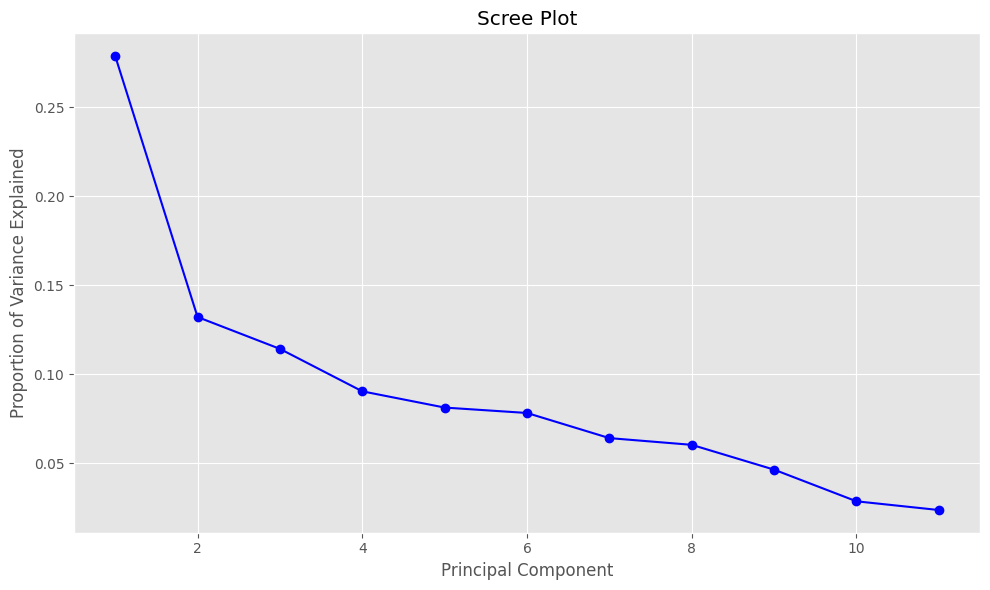

In [178]:
explained_variance_ratio = pca_white.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(explained_variance_ratio) + 1, 1), explained_variance_ratio, "bo-"
)
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.title("Scree Plot")

plt.grid(True)

plt.tight_layout()
plt.show()

In [179]:
print("Explained Variance Ratio:")
print(f"PC1: {pca_white.explained_variance_ratio_[0]:.4f}")
print(f"PC2: {pca_white.explained_variance_ratio_[1]:.4f}")
print(f"PC3: {pca_white.explained_variance_ratio_[2]:.4f}")
print(f"\nTotal Variance Explained:")
print(
    f"PC1 + PC2: {pca_white.explained_variance_ratio_[0] + pca_white.explained_variance_ratio_[1]:.4f}"
)
print(
    f"PC2 + PC3: {pca_white.explained_variance_ratio_[1] + pca_white.explained_variance_ratio_[2]:.4f}"
)

Explained Variance Ratio:
PC1: 0.2789
PC2: 0.1322
PC3: 0.1143

Total Variance Explained:
PC1 + PC2: 0.4111
PC2 + PC3: 0.2464


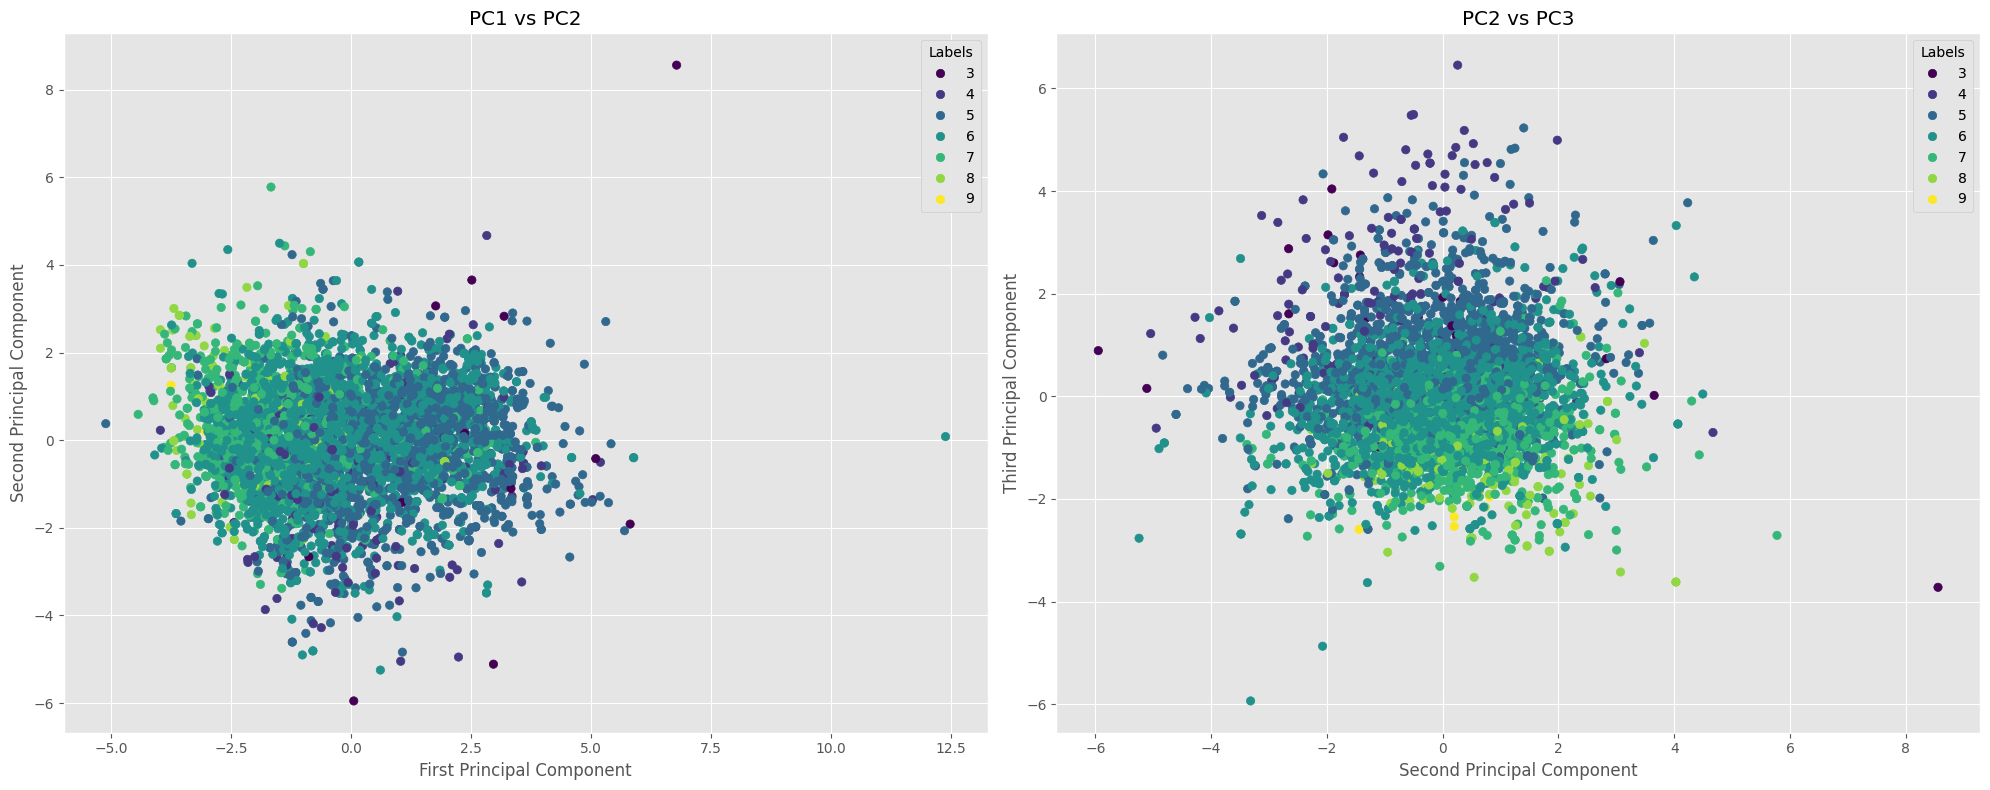

In [180]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

scatter1 = ax1.scatter(components_white[:, 0], components_white[:, 1], c=labels_white)
ax1.set_xlabel("First Principal Component")
ax1.set_ylabel("Second Principal Component")
ax1.set_title("PC1 vs PC2")
ax1.grid(True)

legend1 = ax1.legend(*scatter1.legend_elements(), title="Labels", loc="upper right")
ax1.add_artist(legend1)

scatter2 = ax2.scatter(components_white[:, 1], components_white[:, 2], c=labels_white)
ax2.set_xlabel("Second Principal Component")
ax2.set_ylabel("Third Principal Component")
ax2.set_title("PC2 vs PC3")
ax2.grid(True)

legend2 = ax2.legend(*scatter2.legend_elements(), title="Labels", loc="upper right")
ax2.add_artist(legend2)

plt.tight_layout()
plt.show()

<h3>Human Activity Dataset</h3>


In [181]:
features_harr = X_train.values
labels_harr = Y_train.values

In [182]:
scaler = StandardScaler()
features_harr_scaled = scaler.fit_transform(features_harr)
pca_harr = PCA(n_components=15)
pca_out_harr = pca_harr.fit_transform(features_harr_scaled)

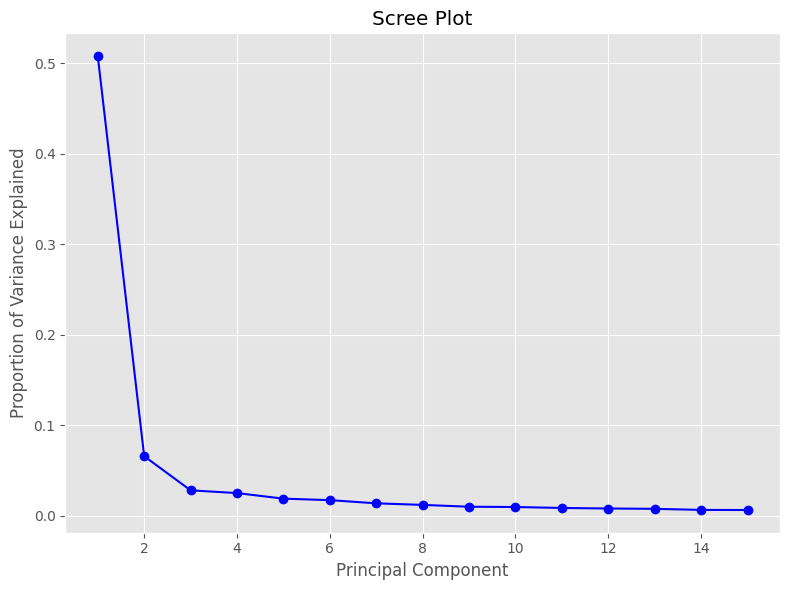

In [189]:
explained_variance_ratio = pca_harr.explained_variance_ratio_
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, "bo-")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.title("Scree Plot")
plt.grid(True)

plt.tight_layout()
plt.show()

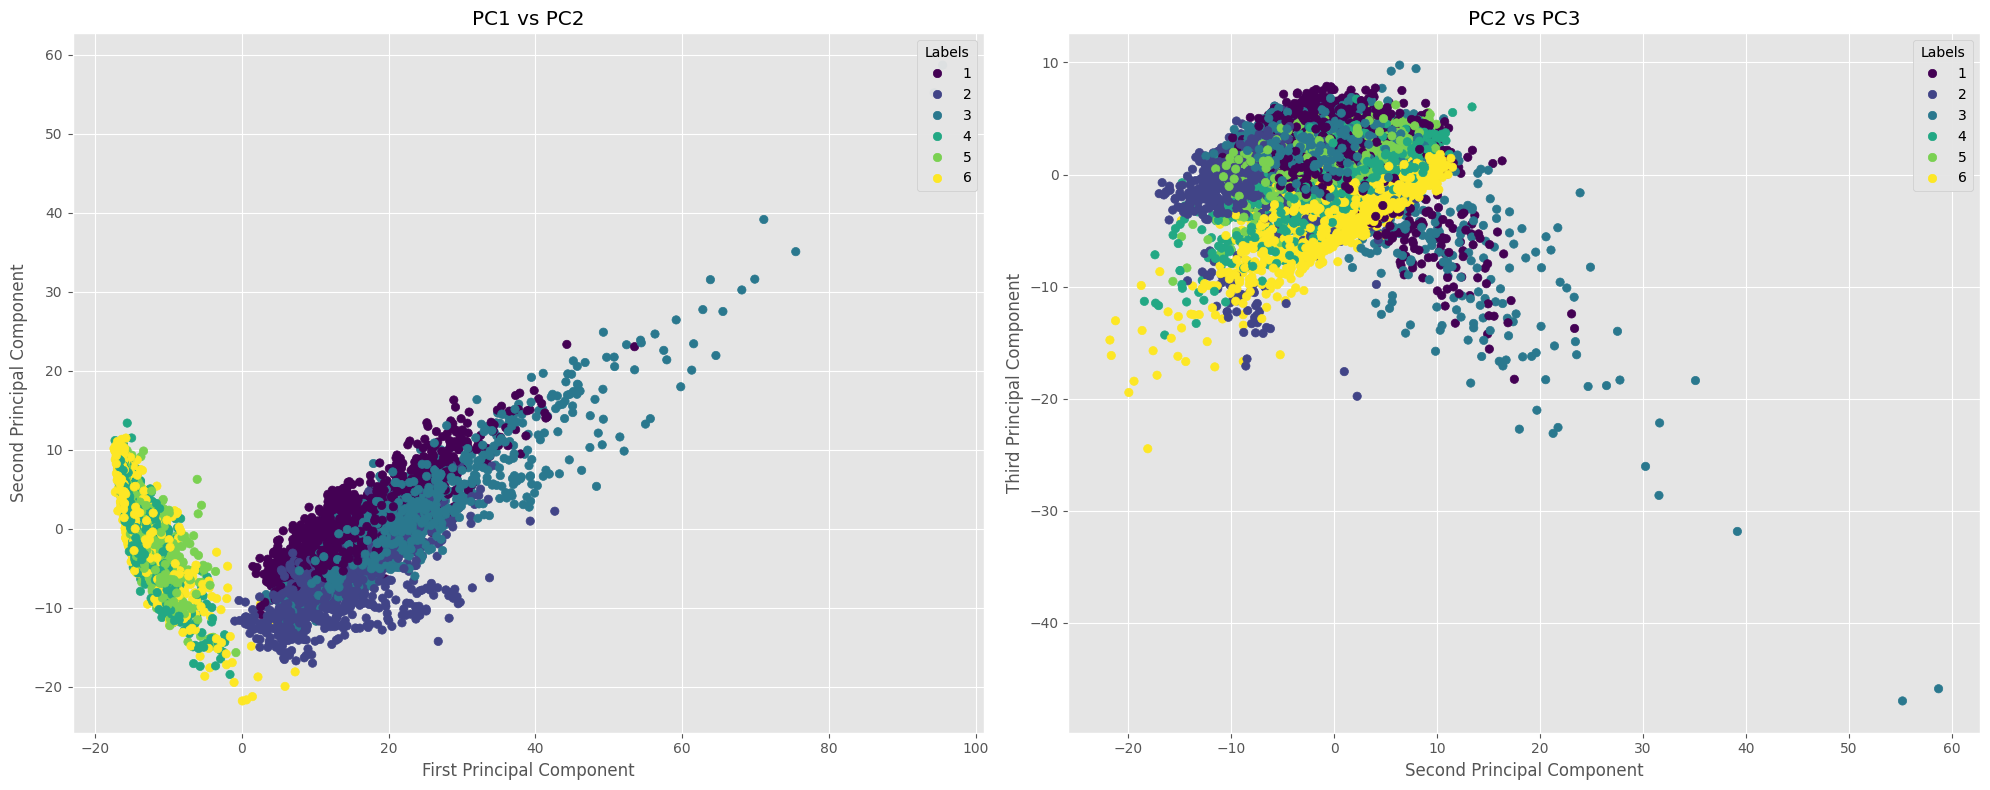

In [185]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

scatter1 = ax1.scatter(pca_out_harr[:, 0], pca_out_harr[:, 1], c=labels_harr)
ax1.set_xlabel("First Principal Component")
ax1.set_ylabel("Second Principal Component")
ax1.set_title("PC1 vs PC2")
ax1.grid(True)

legend1 = ax1.legend(*scatter1.legend_elements(), title="Labels", loc="upper right")
ax1.add_artist(legend1)

scatter2 = ax2.scatter(pca_out_harr[:, 1], pca_out_harr[:, 2], c=labels_harr)
ax2.set_xlabel("Second Principal Component")
ax2.set_ylabel("Third Principal Component")
ax2.set_title("PC2 vs PC3")
ax2.grid(True)

legend2 = ax2.legend(*scatter2.legend_elements(), title="Labels", loc="upper right")
ax2.add_artist(legend2)

plt.tight_layout()
plt.show()

This question applied Gaussian classification techniques to two real-world datasets: Wine Quality and Human Activity Recognition.

Wine Quality Dataset

The Gaussian model showed poor performance:
Red Wine: P(error) = 0.4028
White Wine: P(error) = 0.4637
Combined Wines: P(error) = 0.4654
PCA analysis:
PC1 explained 27.89% of variance
PC1 + PC2 explained 41.11% of variance

Human Activity Dataset

The Gaussian model performed significantly better:
Training Data: P(error) = 0.0125
Test Data: P(error) = 0.0584
PCA analysis:
PC1 explained 50.78% of variance
PC1 + PC2 explained 57.36% of variance

Conclusion

The Gaussian model performed much better on the Human Activity dataset than on the Wine Quality dataset. This suggests that the nature of the data in the Human Activity dataset is more suitable for Gaussian classification techniques. The PCA results further support this conclusion, showing that the Human Activity data has more concentrated information in its first few principal components.
These findings underscore the importance of carefully selecting classification methods based on the characteristics of the dataset at hand. Future work could explore alternative classification methods for datasets like Wine Quality, where Gaussian models show limitations.


From the results, it can be inferred that Gaussian models may not always be the advisable choice for solving classification models where we do not possess domain knowledge of the problem. The Perror is significantly higher in case of the Wine Quality data showing the model not being appropriate for the set. There is a possibility that the class posteriors were highly influenced by the priors selected based on the sample count, resulting in misleading results on new samples. For the second dataset, a Gaussian classifier tends to yield better results as compared to the Wine Quality Classification problem. PCA helps as an effective tool to identify meaningful information from the abundant feature set. But the Principal Components for the Human Activity Dataset have more data than that of the Wine Quality Dataset, this is visible in the Spree Plot of the explained variance ratios.
